# Workshop 2: Image Classification

Image classification is the process of assigning categories to pixels of satellite or aerial images, based on their spectral characteristics, to identify different types of land cover such as forest, water or urban areas.

Geoprocesamiento 2025-1S  
Universidad Nacional de Colombia

## 0. Requirements 🗒️

For the implementation of the code an image was created in Docker with a Python programming language available for download through __*“docker pull petebunting/au-eoed ”*__ which contains the necessary libraries and with the versions compatible and working correctly in this practical case.

### Import modules

In [1]:
# Import modules from python standard library
import os
import pprint
import random

# Import Geopandas for vector analysis (https://geopandas.org)
import geopandas

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import rsgislib.tools.plotting as rsg_plot
import rsgislib.tools.mapping as rsg_map


# scikit-learn imports
from sklearn.model_selection import GridSearchCV

In [2]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box, mapping

import pandas as pd
import geopandas as gpd
import numpy as np
from osgeo import gdal

## 1. Input data 📂

### Input raster data

Read Sentinel-2 image

In [ ]:
input_img_full = "notebooks/Taller2/image_export3.tif"

#Define the area of interest for clipping
min_x, min_y, max_x, max_y = 400000, 130000, 470000, 200000

# Clip the image using GDAL
gdal.Translate('notebooks/Taller2/clip_image.tif', input_img_full, projWin=[min_x, max_y, max_x, min_y])


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7563fb1f2c10> >

In [ ]:
input_img = "notebooks/Taller2/clip_image.tif"

with rasterio.open(input_img) as src:
    print("Raster CRS:", src.crs)

Raster CRS: EPSG:32618


In [ ]:
# Get the bounding box.
img_bbox = rsgislib.imageutils.get_img_bbox(input_img)
print(img_bbox)

(400000.0, 470000.0, 130000.0, 200000.0)


Image mask generation

In [7]:

# Abrir la imagen original para obtener metadatos
with rasterio.open(input_img) as src:
    perfil = src.profile
    ancho = src.width
    alto = src.height
    bandas = src.count
    transformacion = src.transform
    crs = src.crs

# Crear una matriz de ceros con la misma forma que la imagen original
# La forma es (bandas, alto, ancho)
mascara = np.ones((alto, ancho), dtype=np.uint8)

# Actualizar el perfil para la nueva imagen
perfil.update({
    'dtype': 'uint8',
    'count': 1,  # Solo una banda
    'nodata': 0
})

# Ruta para guardar la máscara binaria
ruta_mascara = 'notebooks/Taller2/imagen_mascara.tif'

# Guardar la máscara binaria
with rasterio.open(ruta_mascara, 'w', **perfil) as dst:
    dst.write(mascara, 1)

In [8]:
in_msk_img = "notebooks/Taller2/imagen_mascara.tif" 

### Input vector data

La capa de información vectorial corresponde a los puntos de entrenamiento que se utilizaran para la clasificacion cobertura del suelo para los Andes colombianos y la Amazonia disponibles en la publicación «A 30 m-resolution land use-land cover product for the Colombian Andes and Amazon using cloud-computing»

https://www.sciencedirect.com/science/article/pii/S0303243422000149#s0060


In [9]:
vec_train_file = "notebooks/Data_geoprocessing/data/Datos_alternos.gpkg" 

lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(vec_train_file)
print(lyr_names )

['Amazontraining', 'Andestraining', 'AmazonTesting', 'AndesTesting', 'AndesTraining_']


Read Andes Amazon Testing and Training layer

In [10]:
# Training
andes_train= geopandas.read_file(vec_train_file, layer=lyr_names[1])
andes_train = andes_train.to_crs("EPSG:32618")

andes_train2= geopandas.read_file(vec_train_file, layer=lyr_names[4])
andes_train2 = andes_train2.to_crs("EPSG:32618")

ama_train= geopandas.read_file(vec_train_file, layer=lyr_names[0])
ama_train = ama_train.to_crs("EPSG:32618")


Join Andes and Amazon Training layers

In [11]:
# Concatenate (stack) them together
andes_ama_concat = pd.concat([andes_train, ama_train, andes_train2], ignore_index=True)
andes_ama_concat = gpd.GeoDataFrame(andes_ama_concat, geometry='geometry', crs=andes_train.crs)

Get bounding box of the image to clip data

Clip `Testing`

In [23]:
test_vec_file = "notebooks/Taller2/Testing.gpkg"

test = geopandas.read_file(test_vec_file, layer=lyr_names[0])

andes_ama_test_clipped = geopandas.clip(test, img_bbox)

andes_ama_test_clipped.to_file("notebooks/Taller2/andes_ama_test_clip2.gpkg", driver="GPKG")

Clip `andes_ama_concat`

In [24]:
# img_bbox should be [minx, maxx, miny, maxy]
minx, maxx, miny, maxy = img_bbox
bbox_geom = box(400000.0, 130000.0, 470000.0, 200000.0)
andes_ama_train_clipped = geopandas.clip(andes_ama_concat, bbox_geom)


Get properties of `andes_ama_train_train_clipped`

In [26]:
print(len(andes_ama_train_clipped))
print(andes_ama_train_clipped["Name"].unique())  # Check name of classes
print(andes_ama_train_clipped.geom_type.unique())
print(andes_ama_train_clipped["Name"].value_counts())  # Check number of samples per class
print(andes_ama_train_clipped.crs)

116
['Water_bodies' 'Agricultural_areas' 'Artificial_surfaces'
 'Agricultural areas' 'Secondary vegetation']
['Polygon' 'Point']
Name
Artificial_surfaces     74
Agricultural areas      23
Agricultural_areas       9
Secondary vegetation     8
Water_bodies             2
Name: count, dtype: int64
EPSG:32618


Save `andes_ama_train_clipped` in local

In [28]:
andes_ama_train_clipped.to_file("notebooks/Taller2/andes_ama_train_clip2.gpkg", driver="GPKG")

Modify manually *clouds* attribute in `andes_ama_train_clipped` in order to get better training polygons for that class.

In [30]:
andes_ama_clip_cloud= geopandas.read_file(r'notebooks/Taller2/andes_ama_train_clip.gpkg')
andes_ama_clip_cloud

Name description timestamp begin end altitudeMode  \
0      Agricultural_areas        None       NaT   NaT NaT         None   
1      Agricultural_areas        None       NaT   NaT NaT         None   
2      Agricultural_areas        None       NaT   NaT NaT         None   
3      Agricultural_areas        None       NaT   NaT NaT         None   
4                  Clouds        None       NaT   NaT NaT         None   
..                    ...         ...       ...   ...  ..          ...   
127  Secondary vegetation        None       NaT   NaT NaT         None   
128    Agricultural areas        None       NaT   NaT NaT         None   
129    Agricultural areas        None       NaT   NaT NaT         None   
130    Agricultural areas        None       NaT   NaT NaT         None   
131  Secondary vegetation        None       NaT   NaT NaT         None   

     tessellate  extrude  visibility  drawOrder  icon landcover  \
0            -1        0          -1        NaN  None         1   
1            -1        0          -1        NaN  None         1   
2            -1        0          -1        NaN  None         1   
3            -1        0          -1        NaN  None         1   
4            -1        0          -1        NaN  None         7   
..          ...      ...         ...        ...   ...       ...   
127          -1        0          -1        NaN  None         6   
128          -1        0          -1        NaN  None         1   
129          -1        0          -1        NaN  None         1   
130          -1        0          -1        NaN  None         1   
131          -1        0          -1        NaN  None         6   

             system_index                                           geometry  
0    00000000000000000560  POLYGON ((416244.734 103224.283, 416546.405 10...  
1    00000000000000000386  POLYGON ((429108.199 106321.075, 429829.591 10...  
2    00000000000000000537  POLYGON ((412259.527 111711.636, 412379.107 11...  
3    00000000000000000538  POLYGON ((412437.149 111683.496, 412616.753 11...  
4    0000000000000000012e  POLYGON ((445181.744 189210.266, 445181.713 18...  
..                    ...                                                ...  
127  0000000000000000032d  POLYGON ((445945.742 193031.126, 446007.745 19...  
128  000000000000000006af  POLYGON ((456904.266 193115.816, 457013.374 19...  
129  000000000000000006af  POLYGON ((456904.266 193115.816, 457013.374 19...  
130  000000000000000006ae  POLYGON ((451971.519 198093.045, 452303.312 19...  
131  00000000000000000330  POLYGON ((455899.682 198927.096, 455990.937 19...  

[132 rows x 14 columns]

Get properties of `andes_ama_clip_cloud`

In [31]:
print(len(andes_ama_clip_cloud))
print(andes_ama_clip_cloud["Name"].unique())  # Check name of classes
print(andes_ama_clip_cloud.geom_type.unique())
print(andes_ama_clip_cloud["Name"].value_counts())  # Check number of samples per class
print(andes_ama_clip_cloud.crs)

132
['Agricultural_areas' 'Clouds' 'Water_bodies' 'Artificial_surfaces'
 'Agricultural areas' 'Secondary vegetation']
['Polygon' 'Point']
Name
Artificial_surfaces     74
Agricultural areas      23
Agricultural_areas      17
Secondary vegetation     8
Clouds                   6
Water_bodies             4
Name: count, dtype: int64
EPSG:32618


Rename *Agricultural_areas* to *Agricultural areas* to have a single column for that class

In [33]:
andes_ama_clip_cloud['Name'] = andes_ama_clip_cloud['Name'].replace({
    'Agricultural areas': 'Agricultural areas',
    'Agricultural_areas': 'Agricultural areas'
})
print(andes_ama_clip_cloud["Name"].unique()) 
categorias_unicas = andes_ama_clip_cloud["Name"].unique()

['Agricultural areas' 'Clouds' 'Water_bodies' 'Artificial_surfaces'
 'Secondary vegetation']


Create a vector layer for each class

In [34]:
# Iterar sobre cada valor único y exportar como una capa separada
for categoria in categorias_unicas:
    # Filtrar el GeoDataFrame por la categoría actual
    andes_ama_train = andes_ama_clip_cloud[andes_ama_clip_cloud['Name'] == categoria]
    
    # Definir el nombre de la capa (puedes ajustar según tus necesidades)
    nombre_capa = str(categoria).replace(' ', '_').lower()
    
    # Escribir la capa en el GeoPackage
    andes_ama_train.to_file(r'notebooks/Taller2/andes_ama_train_final.gpkg', layer=nombre_capa, driver='GPKG', mode='a')

# Vector points

In [35]:
lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(vec_train_file)
print(lyr_names )

['Amazontraining', 'Andestraining', 'AmazonTesting', 'AndesTesting', 'AndesTraining_']


Read Andes Testing layer

In [36]:
andes_test= geopandas.read_file(vec_train_file, layer=lyr_names[3])
andes_test = andes_test.to_crs("EPSG:32618")
andes_test.head()

Classified  Reference                       geometry
0           1          1  POINT (331911.701 383932.977)
1           1          1  POINT (721833.326 620077.725)
2           1          1   POINT (332629.07 383127.267)
3           1          1   POINT (433824.813 690458.95)
4           1          1  POINT (335469.699 434555.038)

Save geopakage with vector layers of each class

In [37]:
andes_ama_train="notebooks/Taller2/andes_ama_train_final.gpkg"

Create a single map that overlays **Sentinel-2 composite** with the **training points/polygons**. The aim is to confirm that every sample truly sits on its intended land-cover type.

**Why do this?**  
Before running any machine-learning routine we need to be certain that:

1. The image subset genuinely covers every training point.  
2. No sample falls on clouds, edge artefacts, or outside the valid-pixel mask.  
3. The spectral composite looks sensible (no band shifts, correct stretch).

Image Data Size: 7000 x 7000


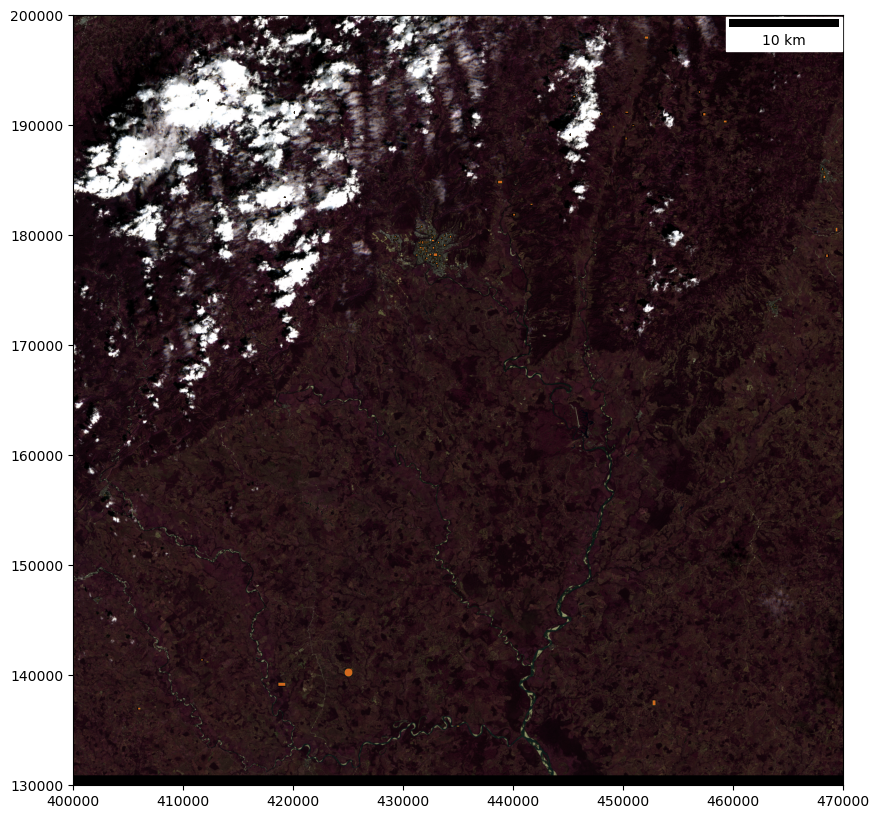

In [38]:
# 1. Define the map window using four OSGB coordinates: xmin, xmax, ymin, ymax (metres).
sub_img_bbox = [400000.0, 470000.0, 130000.0, 200000.0]

# ---------------------------------------------------------
# 2. Prepare a Matplotlib canvas
#    One axis, 10 × 10 inches – large enough for legible detail.
fig, ax = plt.subplots(figsize=(10, 10))
# ---------------------------------------------------------
# 3. Draw a Sentinel-2 RGB composite
#    * input_img       : full multispectral stack
#    * img_bands       : [8 (NIR), 9 (red-edge), 3 (green)]
#    * img_stch        : cumulative histogram stretch for contrast
#    * bbox            : clip to the subset
#    * show_scale_bar  : adds a 5 km bar bottom-left
# ---------------------------------------------------------
rsgislib.tools.mapping.create_raster_img_map(
    ax,
    input_img,
    img_bands=[5, 4, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)

# ---------------------------------------------------------
# 4. Build a palette of distinct colours
#    CSS4 provides ~140 named colours; we convert the dict keys
#    to a list so random.choice can pick from it.
mpl_clrs = list(mcolors.CSS4_COLORS.keys())

# Lists to store GeoPandas layers and their display colours
gp_vecs  = []
lyr_clrs = []

# ---------------------------------------------------------
# 5. Load each training layer and assign a random colour
#    * lyr_names        : list of class layers in the GeoPackage
#    * vec_train_file   : path to the training samples (GPKG)
for lyr_name in lyr_names:
    # Read the class layer as a GeoDataFrame
    gp_vecs.append(andes_ama_clip_cloud)
    # Pick a random CSS colour to fill that class
    lyr_clrs.append(random.choice(mpl_clrs))

# ---------------------------------------------------------
# 6. Overlay the training vectors on the RGB image
#    * gp_vecs         : list of GeoDataFrames (one per class)
#    * vec_fill_clrs   : matching list of fill colours
#    * vec_line_clrs   : outline colour (“black” for all)
#    * bbox            : ensures vectors are clipped to the subset
#    * show_scale_bar  : False – we already drew one above
# ---------------------------------------------------------
rsgislib.tools.mapping.create_vec_lyr_map(
    ax,
    gp_vecs=gp_vecs,
    bbox=sub_img_bbox,
    vec_fill_clrs=lyr_clrs,
    vec_line_clrs="black",
    show_scale_bar=False,
)


Extract training samples

Define images and bands for classification

In [39]:
img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )
)
print(img_band_info)

[('sen2', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'notebooks/Taller2/clip_image.tif')]


In [40]:
lyr_names2 = rsgislib.vectorutils.get_vec_lyrs_lst(r'notebooks/Taller2/andes_ama_train_final.gpkg')
print(lyr_names2 )


['agricultural_areas', 'clouds', 'water_bodies', 'artificial_surfaces', 'secondary_vegetation']


Define the class and the vector samples

In [41]:
class_vec_sample_info = list()

# Define the file name of the samples HDF5 file, which will be created
agricultural_areas_h5 = "notebooks/Taller2/h5/agricultural_areas_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="agricultural_areas",
        vec_file=andes_ama_train,
        vec_lyr="agricultural_areas",
        file_h5=agricultural_areas_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
clouds_h5 = "notebooks/Taller2/h5/clouds_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="clouds",
        vec_file=andes_ama_train,
        vec_lyr="clouds",
        file_h5=clouds_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
water_bodies_h5 = "notebooks/Taller2/h5/water_bodies_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="water_bodies",
        vec_file=andes_ama_train,
        vec_lyr="water_bodies",
        file_h5=water_bodies_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
artificial_surfaces_h5 = "notebooks/Taller2/h5/artificial_surfaces_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="artificial_surfaces",
        vec_file=andes_ama_train,  #vec_train_file
        vec_lyr="artificial_surfaces",
        file_h5=artificial_surfaces_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
secondary_vegetation_h5 = "notebooks/Taller2/h5/secondary_vegetation_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="secondary_vegetation",
        vec_file=andes_ama_train,
        vec_lyr="secondary_vegetation",
        file_h5=secondary_vegetation_h5,
    )
)


## See what is inside  class_vec_sample_info
print(class_vec_sample_info)

[<rsgislib.classification.ClassVecSamplesInfoObj object at 0x7563fa508b10>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7563f9a60750>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7563f9ab8910>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7563f9da6590>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7563f9b4f490>]


In [42]:
obj = class_vec_sample_info[0]
vars(obj)        # returns a dictionary of attributes
# or
obj.__dict__


{'id': 1,
 'class_name': 'agricultural_areas',
 'vec_file': 'notebooks/Taller2/andes_ama_train_final.gpkg',
 'vec_lyr': 'agricultural_areas',
 'file_h5': 'notebooks/Taller2/h5/agricultural_areas_smpls.h5'}

In [43]:
tmp_dir = "notebooks/Taller2/h5"

if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

In [44]:
cls_smpls_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_info, tmp_dir, ref_img=in_msk_img
)

Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Creating output image using input image


Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




In [45]:
cls_smpls_info


{'agricultural_areas': 1: notebooks/Taller2/h5/agricultural_areas_smpls.h5, (78, 10, 46),
 'clouds': 2: notebooks/Taller2/h5/clouds_smpls.h5, (194, 252, 118),
 'water_bodies': 3: notebooks/Taller2/h5/water_bodies_smpls.h5, (99, 42, 191),
 'artificial_surfaces': 4: notebooks/Taller2/h5/artificial_surfaces_smpls.h5, (55, 247, 85),
 'secondary_vegetation': 5: notebooks/Taller2/h5/secondary_vegetation_smpls.h5, (38, 43, 63)}

Define Class Colours

In [46]:
cls_smpls_info["artificial_surfaces"].red = 180
cls_smpls_info["artificial_surfaces"].green = 180
cls_smpls_info["artificial_surfaces"].blue = 180

cls_smpls_info["agricultural_areas"].red = 131
cls_smpls_info["agricultural_areas"].green = 250
cls_smpls_info["agricultural_areas"].blue = 252

cls_smpls_info["clouds"].red = 0
cls_smpls_info["clouds"].green = 105
cls_smpls_info["clouds"].blue = 16

cls_smpls_info["water_bodies"].red = 62
cls_smpls_info["water_bodies"].green = 168
cls_smpls_info["water_bodies"].blue = 78

cls_smpls_info["secondary_vegetation"].red = 247
cls_smpls_info["secondary_vegetation"].green = 176
cls_smpls_info["secondary_vegetation"].blue = 32

cls_smpls_info

{'agricultural_areas': 1: notebooks/Taller2/h5/agricultural_areas_smpls.h5, (131, 250, 252),
 'clouds': 2: notebooks/Taller2/h5/clouds_smpls.h5, (0, 105, 16),
 'water_bodies': 3: notebooks/Taller2/h5/water_bodies_smpls.h5, (62, 168, 78),
 'artificial_surfaces': 4: notebooks/Taller2/h5/artificial_surfaces_smpls.h5, (180, 180, 180),
 'secondary_vegetation': 5: notebooks/Taller2/h5/secondary_vegetation_smpls.h5, (247, 176, 32)}

How many training samples were extracted

In [48]:
for cls_name in cls_smpls_info:
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    n_smpls = rsgislib.classification.get_num_samples(smpls_h5_file)
    print(f"{cls_name}: {n_smpls}")

agricultural_areas: 11201
clouds: 429
water_bodies: 270
artificial_surfaces: 11406
secondary_vegetation: 558


Balance and Extract Training / Validation and Testing datasets

In [49]:
# Define the output directory and create if it does not exist:
smpls_dir = "notebooks/Taller2/cls_smpls"

if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)


cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(
    cls_smpls_info, smpls_dir
)

print("\n keys",cls_smpls_fnl_info.keys())

# print the values of artificail_surfaces
print("\n keys",cls_smpls_fnl_info["artificial_surfaces"])

0=1: (Train:notebooks/Taller2/cls_smpls/agricultural_areas_smpls_train.h5, Test:notebooks/Taller2/cls_smpls/agricultural_areas_smpls_test.h5, Valid:notebooks/Taller2/cls_smpls/agricultural_areas_smpls_valid.h5), (131, 250, 252)
1=2: (Train:notebooks/Taller2/cls_smpls/clouds_smpls_train.h5, Test:notebooks/Taller2/cls_smpls/clouds_smpls_test.h5, Valid:notebooks/Taller2/cls_smpls/clouds_smpls_valid.h5), (0, 105, 16)
2=3: (Train:notebooks/Taller2/cls_smpls/water_bodies_smpls_train.h5, Test:notebooks/Taller2/cls_smpls/water_bodies_smpls_test.h5, Valid:notebooks/Taller2/cls_smpls/water_bodies_smpls_valid.h5), (62, 168, 78)
3=4: (Train:notebooks/Taller2/cls_smpls/artificial_surfaces_smpls_train.h5, Test:notebooks/Taller2/cls_smpls/artificial_surfaces_smpls_test.h5, Valid:notebooks/Taller2/cls_smpls/artificial_surfaces_smpls_valid.h5), (180, 180, 180)
4=5: (Train:notebooks/Taller2/cls_smpls/secondary_vegetation_smpls_train.h5, Test:notebooks/Taller2/cls_smpls/secondary_vegetation_smpls_test.h5

Run the create_train_valid_test_sets helper function to create the train, valid and test datasets

In [52]:
# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 27, 27, 216
)

You now have three HDF5 files for each class (look within the `cls_smpls` directory) with these defining the pixels extracted from the scene for training, validating and testing the classifier. 

If you want to see what is within one of these HDF5 files you can use the h5dump command as show below (note, when using a jupyter notebook a line starting with `!` means it will be run as a command tool rather than Python code.

Within the HDF5 file you can see the that there are 51 samples and that each as 10 values (i.e., the Sentinel-2 bands we specified to be extracted earlier). 

In [53]:
!h5dump notebooks/Taller2/cls_smpls/agricultural_areas_smpls_valid.h5

HDF5 "notebooks/Taller2/cls_smpls/agricultural_areas_smpls_valid.h5" {
GROUP "/" {
   GROUP "DATA" {
      DATASET "DATA" {
         DATATYPE  H5T_IEEE_F32LE
         DATASPACE  SIMPLE { ( 34, 10 ) / ( H5S_UNLIMITED, 10 ) }
         DATA {
         (0,0): 413, 744, 1040, 953, 1611, 2921, 3078, 3372, 3287, 5122,
         (1,0): 686, 553, 692, 634, 1404, 2825, 3395, 3332, 3746, 5938,
         (2,0): 281, 483, 848, 915, 1547, 3012, 3345, 3415, 3686, 3708,
         (3,0): 288, 464, 822, 693, 1383, 2881, 3391, 3504, 3654, 3671,
         (4,0): 268, 561, 980, 1368, 1506, 2301, 2514, 2640, 2753, 2787,
         (5,0): 268, 422, 672, 877, 1224, 1869, 2173, 2198, 2461, 2787,
         (6,0): 236, 318, 634, 449, 1084, 2623, 3257, 3385, 3561, 3516,
         (7,0): 223, 314, 542, 384, 987, 2455, 3047, 3119, 3346, 3645,
         (8,0): 234, 335, 639, 567, 1211, 2558, 2936, 3189, 3339, 3268,
         (9,0): 280, 458, 739, 649, 1215, 2654, 3160, 3262, 3614, 3427,
         (10,0): 269, 517, 678, 546, 12

### 4. Train the Classifier


##### 4.1 Optimise Classifier Parameters

In [54]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 20, 50, 100, 150, 200],
        "max_depth": [4, 8, 10, 12, 14, 16],
    },
)
print(grid_search )
sk_classifier = (
    rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
        cls_smpls_fnl_info, grid_search
    )
)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 8, 10, 12, 14, 16],
                         'n_estimators': [10, 20, 50, 100, 150, 200]})
Training data size: 149 x 10
Best score was 0.9259770114942529 and has parameters {'max_depth': 10, 'n_estimators': 10}.


#### 4.2 Train Optimised Classifier

Now we have the optimised classifier parameters we can train on the full dataset. 

In [55]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

Training data size: 1099 x 10
Testing data size: 150 x 10
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 99.91%
Classifier Test Score = 97.33%


(0.9990900818926297, 0.9733333333333334)

### 5. Apply Classifier

In [56]:
out_cls_img = "notebooks/Taller2/image_cls.kea"
out_scr_img = "notebooks/Taller2/image_cls_score.kea"

rsgislib.classification.classsklearn.apply_sklearn_classifier(
    cls_smpls_fnl_info,
    sk_classifier,
    in_msk_img=in_msk_img,
    img_msk_val=1,
    img_file_info=img_band_info,
    out_class_img=out_cls_img,
    gdalformat="KEA",
    class_clr_names=True,
    out_score_img=out_scr_img,
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Calculating Image Pyramids.





Apply Colour to class 'agricultural_areas'
Apply Colour to class 'clouds'
Apply Colour to class 'water_bodies'
Apply Colour to class 'artificial_surfaces'
Apply Colour to class 'secondary_vegetation'


#### 6. Visual Classification Results

Image Data Size: 7000 x 7000


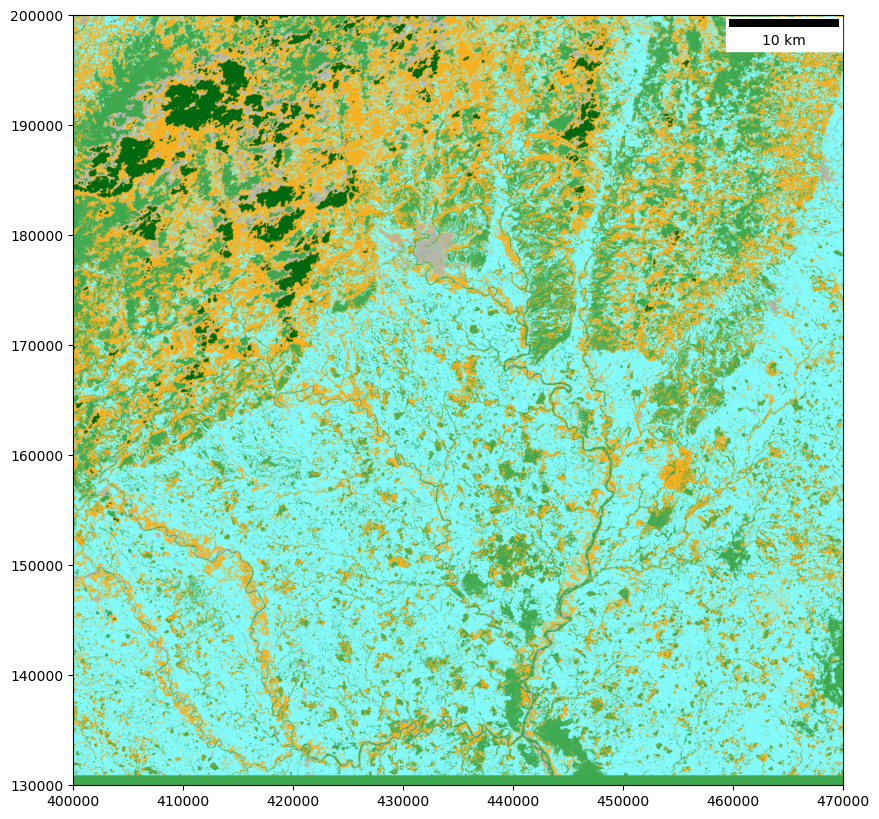

In [57]:
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

rsgislib.tools.mapping.create_thematic_raster_map(ax, out_cls_img)

#### 6.1 Visualise Subsets

Image Data Size: 7000 x 7000
Image Data Size: 7000 x 7000


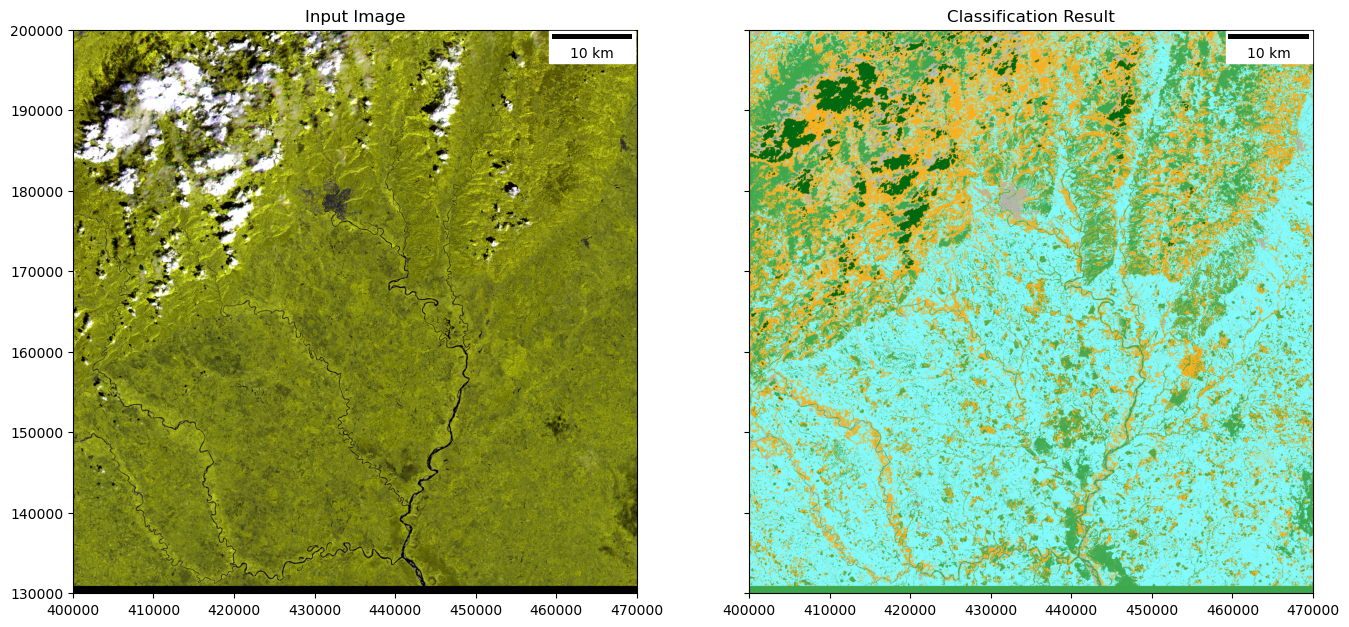

In [58]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [399940.0, 470000.0, 90250.0, 200050.0]
# sub_img_bbox = [255000, 280000, 275000, 300000]
# sub_img_bbox = [295000, 300000, 295000, 300000]

# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Add the Sentinel-2 image to the axis
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)
ax1.title.set_text("Input Image")

# Add the classification to the seocnd axis.
rsgislib.tools.mapping.create_thematic_raster_map(ax2, out_cls_img, bbox=sub_img_bbox)
ax2.title.set_text("Classification Result")

#### 6.2 Create Legend

Max. characters in class name: 20
Column width: 132
Image: 276 x  82


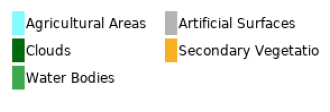

In [59]:
# ------------------------------------------------------------------
# 1. Build legend's dictionary based on raster
#    (ajusta 'class_names' si tu campo tiene otro nombre)
# ------------------------------------------------------------------
cls_info = rsg_plot.create_legend_info_dict(
    out_cls_img,
    cls_names_col="class_names",
    use_title_case=True,
    underscore_to_space=True,
)

# ------------------------------------------------------------------
# 2. Localizar una fuente TrueType que sí exista
#    DejaVu Sans viene con Matplotlib y está en casi todos los entornos
# ------------------------------------------------------------------
font_path = fm.findfont("DejaVu Sans", fallback_to_default=True)

# ------------------------------------------------------------------
# 3. Dibujar la leyenda sobre un eje Matplotlib
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4, 4))

rsg_plot.create_legend_img_mpl_ax(
    ax,
    legend_info=cls_info,
    n_cols=2,          # número de columnas de la leyenda
    font=font_path,    # ruta TTF garantizada
)

plt.show()


#### 6.3 Show Legend Alongside Map

Image Data Size: 7000 x 7000
Image Data Size: 7000 x 7000
Max. characters in class name: 20
Column width: 132
Image: 276 x  82


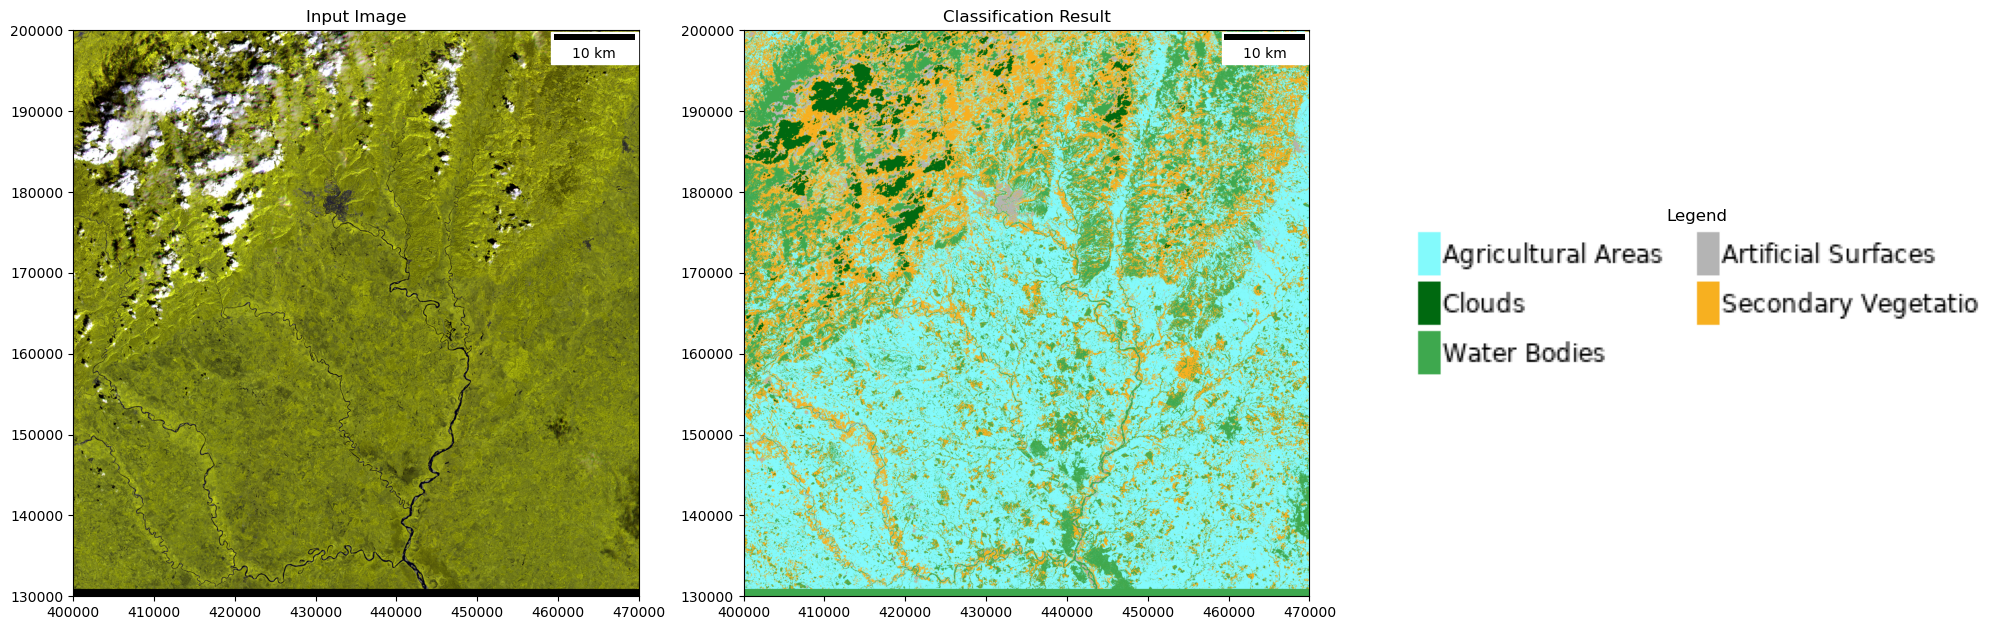

In [60]:
# 1. Legend dictionary (already created earlier as `cls_info`)
#    cls_info = rsg_plot.create_legend_info_dict(...)
# ------------------------------------------------------------

# 2. Find a reliable TrueType font (DejaVu Sans ships with Matplotlib)
font_path = fm.findfont("DejaVu Sans", fallback_to_default=True)

# 3. Build a 3-panel figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), sharey=False)

# ---- Sentinel-2 RGB composite (bands 8-9-3) ----
rsg_map.create_raster_img_map(
    ax1,
    input_img,                       # Sentinel-2 subset (KEA / GeoTIFF)
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)
ax1.set_title("Input Image")

# ---- Pixel-based classification map ----
rsg_map.create_thematic_raster_map(
    ax2,
    out_cls_img,                     # Classified raster
    bbox=sub_img_bbox
)
ax2.set_title("Classification Result")

# ---- Legend panel (font argument prevents OSError) ----
rsg_plot.create_legend_img_mpl_ax(
    ax3,
    legend_info=cls_info,
    n_cols=2,                        # Columns in the legend table
    font=font_path                   # Explicit TTF path → no “cannot open resource”
)
ax3.set_title("Legend")

plt.tight_layout()
plt.show()


## Classification Metrics

- **Confusion Matrix**: shows the relationship between predicted and actual classes. For binary classification (e.g., vegetation presence vs absence), it looks like:

    |                   | Predicted: Positive | Predicted: Negative |
    |-------------------|---------------------|---------------------|
    | **Actual: Positive** | True Positive (TP)   | False Negative (FN)  |
    | **Actual: Negative** | False Positive (FP)  | True Negative (TN)   |

- **TP (True Positive):** Correctly predicted positive cases.
- **TN (True Negative):** Correctly predicted negative cases.
- **FP (False Positive):** Incorrectly predicted as positive (*commission error*).
- **FN (False Negative):** Incorrectly predicted as negative (*omission error*).

- **Precision**: The proportion of positive predictions that were actually correct.

- **Recall (Sensitivity)**: The proportion of actual positives that were correctly identified.

- **F1-Score**: The harmonic mean of precision and recall. Useful for imbalanced datasets.

- **Overall Accuracy**: The proportion of all predictions that were correct.

- **Commission Error**: The proportion of samples incorrectly assigned to a class.

- **Omission Error**: The proportion of samples that should have been assigned to a class but were not.

- **Error Types**: 

    - **Type I Error (False Positive):** Incorrectly predicting the positive class (*commission*).
    - **Type II Error (False Negative):** Failing to detect a positive case (*omission*).

- **Cohen’s Kappa (κ)**: Measures the agreement between predictions and true labels, correcting for chance agreement.

    -  **Kappa interpretation**: 

        - \( p_o \): Observed agreement (accuracy)
        - \( p_e \): Expected agreement by chance

            | Kappa Value | Interpretation         |
            |-------------|-------------------------|
            | < 0         | Poor agreement          |
            | 0.01–0.20   | Slight agreement        |
            | 0.21–0.40   | Fair agreement          |
            | 0.41–0.60   | Moderate agreement      |
            | 0.61–0.80   | Substantial agreement   |
            | 0.81–1.00   | Almost perfect agreement |

---

### Summary Table of Metrics

| Metric               | Formula                                     | Interpretation                                  |
|----------------------|---------------------------------------------|--------------------------------------------------|
| Precision            | $ \frac{TP}{TP + FP} $                      | Correct positive predictions / total predicted positives |
| Recall (Sensitivity) | $ \frac{TP}{TP + FN} $                      | Detected positives / actual positives           |
| F1-Score             | $ 2 \cdot \frac{P \cdot R}{P + R} $         | Balance between precision and recall            |
| Accuracy             | $ \frac{TP + TN}{TP + TN + FP + FN} $      | Overall correctness                             |
| Commission Error     | $ \frac{FP}{TP + FP} $                      | False assignments to a class                    |
| Omission Error       | $ \frac{FN}{TP + FN} $                      | Missed cases that belong to a class             |
| Kappa (κ)            | $ \frac{p_o - p_e}{1 - p_e} $               | Agreement corrected for chance                  |


XGBoost Classification